In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import nibabel as nib
from pycip.chart import Chart, ChartGroup
import os
from skimage.transform import rescale
from skimage.measure import label
from scipy.ndimage import binary_fill_holes
import pyvista as pv

%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
body_dataset = json.load(open('G:/mipresearch/mps_data/body/body_dataset.json'))
cochlear_dataset = json.load(open('G:/mipresearch/mps_data/cochlear/cochlear_dataset.json'))

for k in ['train', 'val', 'test']:
    print('body', k, len(body_dataset[k]))
    print('cochlear', k, len(cochlear_dataset[k]))

body train 205
cochlear train 367
body val 30
cochlear val 50
body test 50
cochlear test 87


In [105]:
body_voxel_sizes = []

for fd in os.listdir('G:/mipresearch/mps_data/body/processed'):
    affine = nib.load(f'G:/mipresearch/mps_data/body/processed/{fd}/img.nii.gz').affine
    body_voxel_sizes.append([affine[0, 0], affine[1, 1], affine[2, 2]])

body_voxel_sizes = np.abs(np.array(body_voxel_sizes))

print(body_voxel_sizes.min(axis=0), body_voxel_sizes.max(axis=0))

[2.26769924 1.69860852 2.09765625] [3.91833043 3.90234375 4.546875  ]


## DICE with different methods

In [3]:
## body

res_body_image_ds4 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best__dice.csv')
res_body_sdf_ds4_loc00 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-downsample4_1/evaluation/epoch_best__dice.csv')
res_body_sdf_ds4_loc55 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r5_corrected1.csv')
res_body_sdf_ds4_loc5x = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_no_loc.csv')
res_body_nnunet = pd.read_csv('G:/mipresearch/mps_data/body/body_nnunet_dice.csv')
res_body_medsam2 = pd.read_csv('E:/dingjie/mipresearch/Medical-SAM2/medsam2_body_dice.csv')

res_body_image_ds4_surface = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best__surface.csv')
res_body_sdf_ds4_loc55_surface = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r5_surface_corrected1.csv')

## cochlear

res_cochlear_image_ds4 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_250__pre_dice.csv')
res_cochlear_sdf_ds4_loc00 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-downsample4_1/evaluation/epoch_398__pre_dice.csv')
res_cochlear_sdf_ds4_loc53 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_3.csv')
res_cochlear_nnunet = pd.read_csv('G:/mipresearch/mps_data/cochlear/cochlear_nnunet_dice.csv')
res_cochlear_medsam2 = pd.read_csv('E:/dingjie/mipresearch/Medical-SAM2/medsam2_cochlear_dice.csv')

res_cochlear_image_ds4_surface = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best__surface.csv')
res_cochlear_sdf_ds4_loc53_surface = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_3_surface.csv')

In [5]:
body_structures = ['heart', 'liver', 'kidney_left', 'kidney_right', 'pancreas']
cochlear_structures = ['md', 'st', 'sv', 'cc']

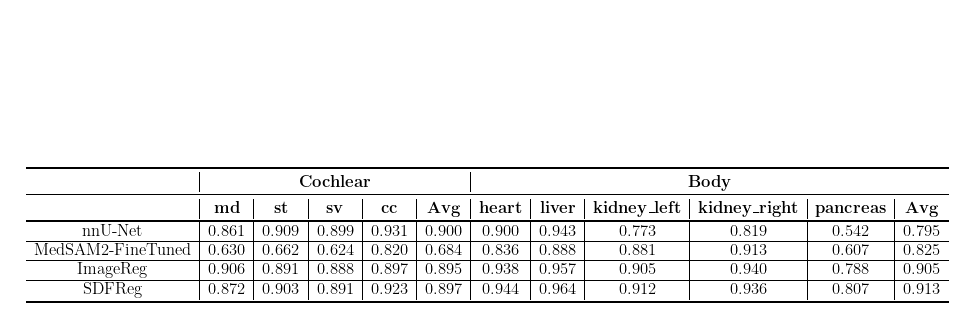

In [42]:
header = [
    [''] + ['Cochlear'] * 5 + ['Body'] * 6,
    [''] + cochlear_structures + ['Avg'] + body_structures + ['Avg']
    ]

table_data = [
    ['nnU-Net'] + [res_cochlear_nnunet[f'{k}_dice'].mean() for k in cochlear_structures] + [res_body_nnunet[f'{k}_dice'].mean() for k in body_structures],
    ['MedSAM2-FineTuned'] + [res_cochlear_medsam2[f'{k}_dice'].mean() for k in cochlear_structures] + [res_body_medsam2[f'{k}_dice'].mean() for k in body_structures],
    ['ImageReg'] + [res_cochlear_image_ds4[f'{k}_dice0'].mean() for k in cochlear_structures] + [res_body_image_ds4[f'{k}_dice'].mean() for k in body_structures],
    ['SDFReg'] + [res_cochlear_sdf_ds4_loc53[f'{k}_dice'].mean() for k in cochlear_structures] + [res_body_sdf_ds4_loc55[f'{k}_dice'].mean() for k in body_structures],
]

for i in range(len(table_data)):
    cochlear_avg = np.array(table_data[i][1: 5]).mean()
    body_avg = np.array(table_data[i][5: ]).mean()
    table_data[i].insert(5, cochlear_avg)
    table_data[i].append(body_avg)

chart = Chart()
chart.table(data=table_data, headers=header, float_format='%.3f')

# pd.DataFrame(header + table_data).to_csv('different_methods_dice.csv', index=False)


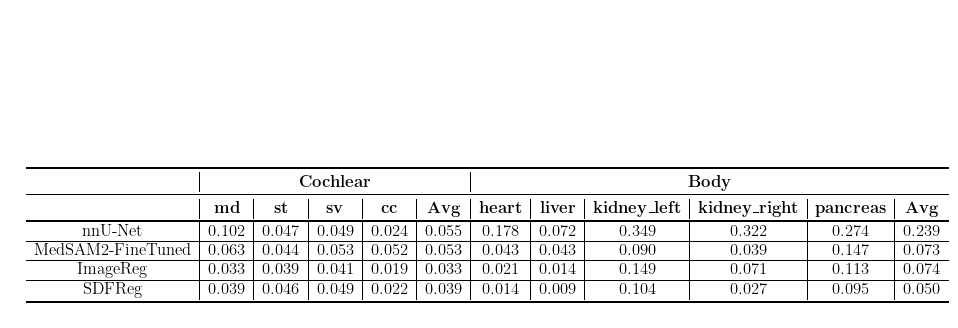

In [9]:
header = [
    [''] + ['Cochlear'] * 5 + ['Body'] * 6,
    [''] + cochlear_structures + ['Avg'] + body_structures + ['Avg']
    ]

table_data = [
    ['nnU-Net'] + [res_cochlear_nnunet[f'{k}_dice'].std() for k in cochlear_structures] + [res_body_nnunet[f'{k}_dice'].std() for k in body_structures],
    ['MedSAM2-FineTuned'] + [res_cochlear_medsam2[f'{k}_dice'].std() for k in cochlear_structures] + [res_body_medsam2[f'{k}_dice'].std() for k in body_structures],
    ['ImageReg'] + [res_cochlear_image_ds4[f'{k}_dice0'].std() for k in cochlear_structures] + [res_body_image_ds4[f'{k}_dice'].std() for k in body_structures],
    ['SDFReg'] + [res_cochlear_sdf_ds4_loc53[f'{k}_dice'].std() for k in cochlear_structures] + [res_body_sdf_ds4_loc55[f'{k}_dice'].std() for k in body_structures],
]

for i in range(len(table_data)):
    cochlear_avg = np.array(table_data[i][1: 5]).mean()
    body_avg = np.array(table_data[i][5: ]).mean()
    table_data[i].insert(5, cochlear_avg)
    table_data[i].append(body_avg)
chart = Chart()
chart.table(data=table_data, headers=header, float_format='%.3f')

pd.DataFrame(header + table_data).to_csv('different_methods_dice_std.csv', index=False)


## Surface error

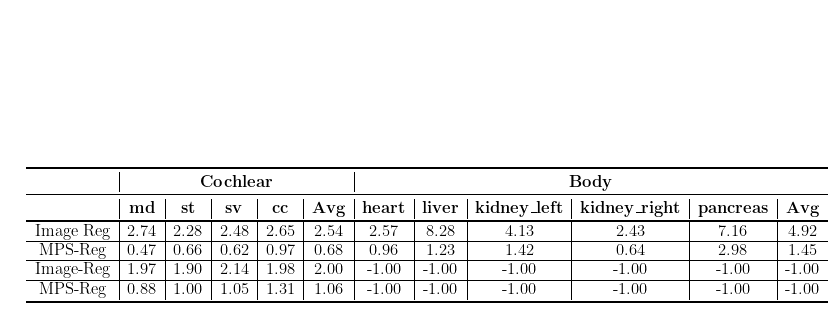

In [27]:
header = [
    [''] + ['Cochlear'] * 5 + ['Body'] * 6,
    [''] + cochlear_structures + ['Avg'] + body_structures + ['Avg']
    ]

table_data = [
    ['Image Reg'] + [res_cochlear_image_ds4_surface[f'{k}_chamfer'].mean() for k in cochlear_structures] + [res_body_image_ds4_surface[f'{k}_chamfer'].mean() for k in body_structures],
    ['MPS-Reg'] + [res_cochlear_sdf_ds4_loc53_surface[f'{k}_chamfer'].mean() for k in cochlear_structures] + [res_body_sdf_ds4_loc55_surface[f'{k}_chamfer'].mean() for k in body_structures],

    ['Image-Reg'] + [res_cochlear_image_ds4_surface[f'{k}_p2p_mean'].mean() for k in cochlear_structures] + [-1] * len(body_structures),
    ['MPS-Reg'] + [res_cochlear_sdf_ds4_loc53_surface[f'{k}_p2p_mean'].mean() for k in cochlear_structures] + [-1] * len(body_structures),
]

for i in range(len(table_data)):
    cochlear_avg = np.array(table_data[i][1: 5]).mean()
    body_avg = np.array(table_data[i][5: ]).mean()
    table_data[i].insert(5, cochlear_avg)
    table_data[i].append(body_avg)

chart = Chart()
chart.table(data=table_data, headers=header, float_format='%.2f')

pd.DataFrame(header + table_data).to_csv('chamfe_and_p2p_error.csv', index=False)


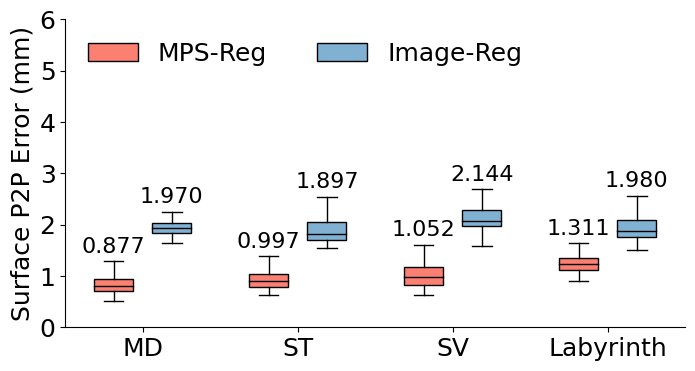

In [16]:
boxplot_data = [
    [res_cochlear_sdf_ds4_loc53_surface[f'{k}_p2p_mean'].to_numpy() for k in cochlear_structures],
    [res_cochlear_image_ds4_surface[f'{k}_p2p_mean'].to_numpy() for k in cochlear_structures],
                ]
chart = Chart().set_figsize(8, 4)
chart.legend_fontsize = 18
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.innertext_fontsize = 16
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)
chart.yticks(0, 6)
chart.ylabel('Surface P2P Error (mm)')
bar_labels = ['MD', 'ST', 'SV', 'Labyrinth']

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

chart.boxplot(boxplot_data, series_labels=['MPS-Reg', 'Image-Reg'], bar_labels=bar_labels, auto_figsize=False, show_stats='mean', stats_format='%.3f', stats_label_y_offset=0.2, legend_frameon=False)


## Multi-Atlas difference

In [10]:
# cochlear
cochlear_atlas0 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_atlas.csv')
cochlear_atlas1 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_1731_PLANID_895_RIGHT.csv')
cochlear_atlas2 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_1735_PLANID_891_RIGHT.csv')
cochlear_atlas3 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_2603_PLANID_360_RIGHT.csv')
cochlear_atlas4 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_2765_PLANID_499_RIGHT.csv')
cochlear_atlas5 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_2801_PLANID_1477_LEFT.csv')
cochlear_atlas6 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_2982_PLANID_2168_RIGHT.csv')
cochlear_atlas7 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_3070_PLANID_2586_LEFT.csv')
cochlear_atlas8 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_3262_PLANID_3594_RIGHT.csv')
cochlear_atlas9 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_PID_3346_PLANID_3775_LEFT.csv')

# body
body_atlas0 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0686.csv')
body_atlas1 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0049.csv')
body_atlas2 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0403.csv')
body_atlas3 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0477.csv')
body_atlas4 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0516.csv')
body_atlas5 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0723.csv')
body_atlas6 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0842.csv')
body_atlas7 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0878.csv')
body_atlas8 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass1340.csv')
body_atlas9 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlas_s0369.csv')

# cochlear
cochlear_img_atlas0 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_250__pre_dice.csv')
cochlear_img_atlas1 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_1731_PLANID_895_RIGHT.csv')
cochlear_img_atlas2 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_1735_PLANID_891_RIGHT.csv')
cochlear_img_atlas3 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_2603_PLANID_360_RIGHT.csv')
cochlear_img_atlas4 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_2765_PLANID_499_RIGHT.csv')
cochlear_img_atlas5 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_2801_PLANID_1477_LEFT.csv')
cochlear_img_atlas6 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_2982_PLANID_2168_RIGHT.csv')
cochlear_img_atlas7 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_3070_PLANID_2586_LEFT.csv')
cochlear_img_atlas8 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_3262_PLANID_3594_RIGHT.csv')
cochlear_img_atlas9 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlas_PID_3346_PLANID_3775_LEFT.csv')

# body
body_img_atlas0 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0686.csv')
body_img_atlas1 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0049.csv')
body_img_atlas2 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0403.csv')
body_img_atlas3 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0477.csv')
body_img_atlas4 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0516.csv')
body_img_atlas5 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0723.csv')
body_img_atlas6 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0842.csv')
body_img_atlas7 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0878.csv')
body_img_atlas8 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass1340.csv')
body_img_atlas9 = pd.read_csv('../exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/evaluation/epoch_best_atlass0369.csv')

In [11]:
cochlear_cases = cochlear_atlas0.case.tolist()
cochlear_atlas_res = [cochlear_atlas0, cochlear_atlas1, cochlear_atlas2, cochlear_atlas3, cochlear_atlas4,
                      cochlear_atlas5, cochlear_atlas6, cochlear_atlas7, cochlear_atlas8, cochlear_atlas9]

cochlear_atlas_data = np.zeros((len(cochlear_structures), len(cochlear_cases), len(cochlear_atlas_res)))
for i, s in enumerate(cochlear_structures):
    for j, case in enumerate(cochlear_cases):
        for k, exp in enumerate(cochlear_atlas_res):
            row = exp[exp.case == case]
            cochlear_atlas_data[i, j, k] = np.array(row[f'{s}_dice'])[0]

body_cases = body_atlas0.case.tolist()

body_atlas_res = [body_atlas0, body_atlas1, body_atlas2, body_atlas3, body_atlas4, 
                  body_atlas5, body_atlas6, body_atlas7, body_atlas8, body_atlas9]

body_atlas_data = np.zeros((len(body_structures), len(body_cases), len(body_atlas_res)))
for i, s in enumerate(body_structures):
    for j, case in enumerate(body_cases):
        for k, exp in enumerate(body_atlas_res):
            row = exp[exp.case == case]
            body_atlas_data[i, j, k] = np.array(row[f'{s}_dice'])[0]


In [12]:
cochlear_cases = cochlear_atlas0.case.tolist()
cochlear_img_atlas_res = [cochlear_img_atlas0, cochlear_img_atlas1, cochlear_img_atlas2, cochlear_img_atlas3, cochlear_img_atlas4,
                      cochlear_img_atlas5, cochlear_img_atlas6, cochlear_img_atlas7, cochlear_img_atlas8, cochlear_img_atlas9]

cochlear_img_atlas_data = np.zeros((len(cochlear_structures), len(cochlear_cases), len(cochlear_atlas_res)))
for i, s in enumerate(cochlear_structures):
    for j, case in enumerate(cochlear_cases):
        for k, exp in enumerate(cochlear_img_atlas_res):
            row = exp[exp.case == case]
            cochlear_img_atlas_data[i, j, k] = np.array(row[f'{s}_dice'])[0]

body_cases = body_atlas0.case.tolist()

body_img_atlas_res = [body_img_atlas0, body_img_atlas1, body_img_atlas2, body_img_atlas3, body_img_atlas4, 
                  body_img_atlas5, body_img_atlas6, body_img_atlas7, body_img_atlas8, body_img_atlas9]

body_img_atlas_data = np.zeros((len(body_structures), len(body_cases), len(body_atlas_res)))
for i, s in enumerate(body_structures):
    for j, case in enumerate(body_cases):
        for k, exp in enumerate(body_img_atlas_res):
            row = exp[exp.case == case]
            body_img_atlas_data[i, j, k] = np.array(row[f'{s}_dice'])[0]


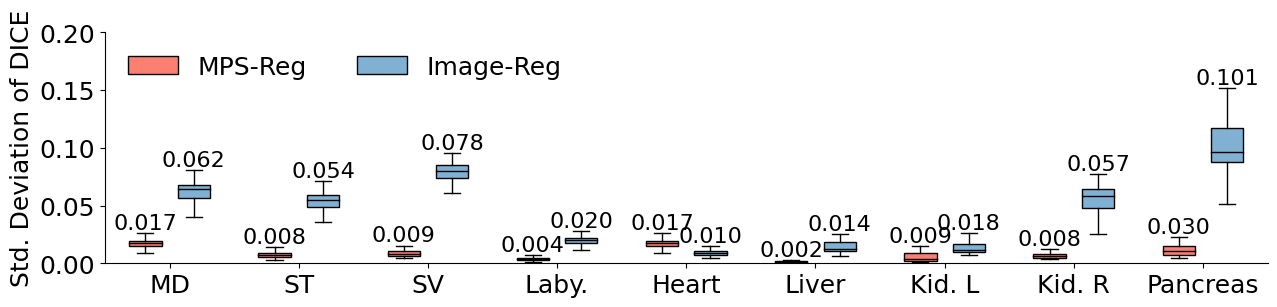

In [103]:
cochlear_atlas_std = np.std(cochlear_atlas_data, axis=2)
body_atlas_std = np.std(body_atlas_data, axis=2)

cochlear_img_atlas_std = np.std(cochlear_img_atlas_data, axis=2)
body_img_atlas_std = np.std(body_img_atlas_data, axis=2)

box_data = [[], []]
for i, s in enumerate(cochlear_structures):
    box_data[0].append(cochlear_atlas_std[i])
for i, s in enumerate(body_structures):
    # for some atlases, the heart mesh has irregularities that lead to falied conversion using Mesh2Mask.exe. We exclude these error cases for now.
    if s == 'heart':
        heart = cochlear_atlas_data[i, :, :]
        heart_stds = []
        for j in range(heart.shape[0]):
            cur = heart[j]
            cur = cur[cur > 0.5]
            heart_stds.append(np.std(cur))
        box_data[0].append(np.array(heart_stds))
    else:
        box_data[0].append(body_atlas_std[i])

for i, s in enumerate(cochlear_structures):
    box_data[1].append(cochlear_img_atlas_std[i])
for i, s in enumerate(body_structures):
    box_data[1].append(body_img_atlas_std[i])

chart = Chart().set_figsize(15, 3)
chart.legend_fontsize = 18
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.innertext_fontsize = 16
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)
chart.yticks(0, 0.20)
chart.ylabel('Std. Deviation of DICE')
bar_labels = ['MD', 'ST', 'SV', 'Laby.', 'Heart', 'Liver', 'Kid. L', 'Kid. R', 'Pancreas']

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

chart.boxplot(box_data, series_labels=['MPS-Reg', 'Image-Reg'], bar_labels=bar_labels, auto_figsize=False, show_stats='mean', stats_format='%.3f', stats_label_y_offset=0.2, legend_frameon=False)


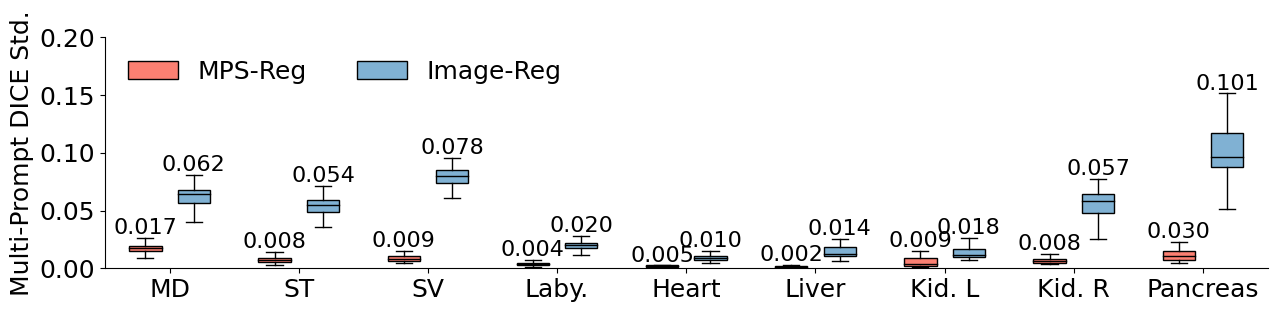

In [62]:
cochlear_atlas_std = np.std(cochlear_atlas_data, axis=2)
body_atlas_std = np.std(body_atlas_data, axis=2)

cochlear_img_atlas_std = np.std(cochlear_img_atlas_data, axis=2)
body_img_atlas_std = np.std(body_img_atlas_data, axis=2)

box_data = [[], []]
for i, s in enumerate(cochlear_structures):
    box_data[0].append(cochlear_atlas_std[i])
for i, s in enumerate(body_structures):
    # for some atlases, the heart mesh has irregularities that lead to falied conversion using Mesh2Mask.exe. We exclude these error cases for now.
    if s == 'heart':
        heart = body_atlas_data[i, :, :]
        heart_stds = []
        for j in range(heart.shape[0]):
            cur = heart[j]
            cur = cur[cur > 0.5]
            heart_stds.append(np.std(cur))
        box_data[0].append(np.array(heart_stds))
    else:
        box_data[0].append(body_atlas_std[i])

for i, s in enumerate(cochlear_structures):
    box_data[1].append(cochlear_img_atlas_std[i])
for i, s in enumerate(body_structures):
    box_data[1].append(body_img_atlas_std[i])

chart = Chart().set_figsize(15, 3)
chart.legend_fontsize = 18
chart.legend_loc = 'upper left'
chart.legend_ncol = 2
chart.innertext_fontsize = 16
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)
chart.yticks(0, 0.20)
chart.ylabel('Multi-Prompt DICE Std.')
bar_labels = ['MD', 'ST', 'SV', 'Laby.', 'Heart', 'Liver', 'Kid. L', 'Kid. R', 'Pancreas']

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

chart.boxplot(box_data, series_labels=['MPS-Reg', 'Image-Reg'], bar_labels=bar_labels, auto_figsize=False, show_stats='mean', stats_format='%.3f', stats_label_y_offset=0.2, legend_frameon=False)


MPS-Reg(MD) v.s Image-Reg(MD):  0.05992383310015699 ns
MPS-Reg(ST) v.s Image-Reg(ST):  1.5601681753183664e-06 ***
MPS-Reg(SV) v.s Image-Reg(SV):  5.078259328399798e-06 ***
MPS-Reg(Laby.) v.s Image-Reg(Laby.):  6.717875635933011e-23 ***
MPS-Reg(Heart) v.s Image-Reg(Heart):  0.008520904347344566 **
MPS-Reg(Liver) v.s Image-Reg(Liver):  4.007511033983572e-12 ***
MPS-Reg(Kid. L) v.s Image-Reg(Kid. L):  0.24725954379274206 ns
MPS-Reg(Kid. R) v.s Image-Reg(Kid. R):  0.006479072599188398 **
MPS-Reg(Pancreas) v.s Image-Reg(Pancreas):  3.407557259076315e-07 ***


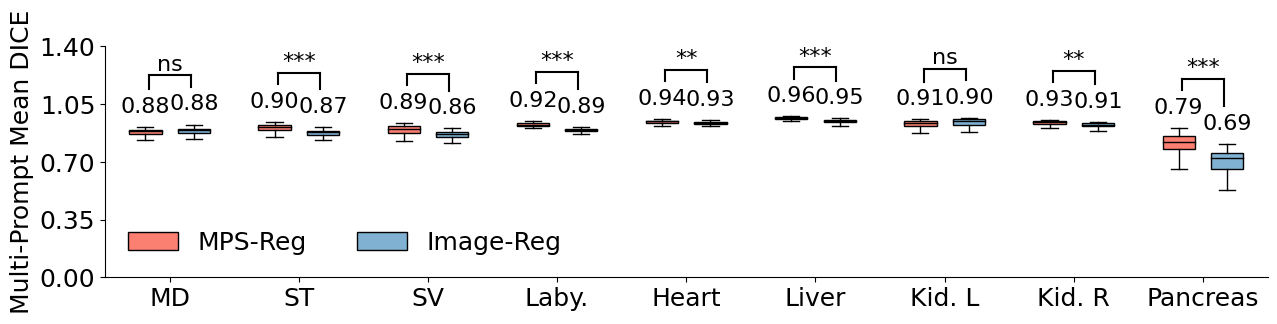

In [69]:
cochlear_atlas_std = np.mean(cochlear_atlas_data, axis=2)
body_atlas_std = np.mean(body_atlas_data, axis=2)

cochlear_img_atlas_std = np.mean(cochlear_img_atlas_data, axis=2)
body_img_atlas_std = np.mean(body_img_atlas_data, axis=2)

box_data = [[], []]
for i, s in enumerate(cochlear_structures):
    box_data[0].append(cochlear_atlas_std[i])
for i, s in enumerate(body_structures):
    # for some atlases, the heart mesh has irregularities that lead to falied conversion using Mesh2Mask.exe. We exclude these error cases for now.
    if s == 'heart':
        heart = body_atlas_data[i, :, :]
        heart_stds = []
        for j in range(heart.shape[0]):
            cur = heart[j]
            cur = cur[cur > 0.5]
            heart_stds.append(np.mean(cur))
        box_data[0].append(np.array(heart_stds))
    else:
        box_data[0].append(body_atlas_std[i])

for i, s in enumerate(cochlear_structures):
    box_data[1].append(cochlear_img_atlas_std[i])
for i, s in enumerate(body_structures):
    box_data[1].append(body_img_atlas_std[i])

chart = Chart().set_figsize(15, 3)
chart.legend_fontsize = 18
chart.legend_loc = 'lower left'
chart.legend_ncol = 2
chart.innertext_fontsize = 16
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)

chart.ylabel('Multi-Prompt Mean DICE')
bar_labels = ['MD', 'ST', 'SV', 'Laby.', 'Heart', 'Liver', 'Kid. L', 'Kid. R', 'Pancreas']

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

sig_pair = [[[0, 0], [0, 1]], [[1, 0], [1, 1]], 
            [[2, 0], [2, 1]], [[3, 0], [3, 1]], 
            [[4, 0], [4, 1]], [[5, 0], [5, 1]], 
            [[6, 0], [6, 1]], [[7, 0], [7, 1]], 
            [[8, 0], [8, 1]]
            ]

chart.boxplot(box_data, series_labels=['MPS-Reg', 'Image-Reg'], 
              bar_labels=bar_labels, auto_figsize=False, show_stats='mean', 
              stats_format='%.2f', stats_label_y_offset=0.1, legend_frameon=False,
              significance_pairs=sig_pair,
              significance_test_method='t-test',
              significance_bar_top_offset=0.2,
              significance_text_y_offest=0.03,
              significance_bar_verticle_line_length_ratio=0.1,
              )

chart.yticks(ticks=[0, 0.35, 0.7, 1.05, 1.4])


In [42]:
box_data[0][4]

array([0.868807, 0.888324, 0.87957 , 0.886748, 0.858374, 0.813848,
       0.891543, 0.901598, 0.889119, 0.904337, 0.876783, 0.884143,
       0.904992, 0.898543, 0.882107, 0.84723 , 0.887107, 0.874279,
       0.849536, 0.88552 , 0.852775, 0.888771, 0.905863, 0.883358,
       0.83188 , 0.901128, 0.894272, 0.885931, 0.909019, 0.869316,
       0.891595, 0.904058, 0.90819 , 0.903799, 0.894663, 0.892714,
       0.874389, 0.872357, 0.888686, 0.884199, 0.877642, 0.862808,
       0.88966 , 0.837868, 0.875296, 0.874964, 0.887261, 0.891659,
       0.864411, 0.864411, 0.884526, 0.896488, 0.83909 , 0.856074,
       0.891246, 0.895123, 0.907011, 0.893305, 0.847054, 0.801528,
       0.85196 , 0.867011, 0.775224, 0.852737, 0.855869, 0.902564,
       0.88355 , 0.86969 , 0.905801, 0.875525, 0.71645 , 0.71905 ,
       0.893386, 0.880545, 0.866944, 0.886879, 0.872064, 0.897801,
       0.887549, 0.885939, 0.874702, 0.899624, 0.903951, 0.895228,
       0.884197, 0.887875, 0.900176])

## Sensitity to location

In [59]:
# cochlear
cochlear_l0 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_0_atlas_atlas.csv')
cochlear_l1 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_1_atlas.csv')
cochlear_l2 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_2_atlas.csv')
cochlear_l3 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_3_atlas.csv')
cochlear_l4 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_4_atlas.csv')
cochlear_l5 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_5_atlas.csv')
cochlear_l6 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_6_atlas.csv')
cochlear_l7 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_7_atlas.csv')
cochlear_l8 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_8_atlas.csv')
cochlear_l9 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_9_atlas.csv')
cochlear_l10 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_10_atlas.csv')
cochlear_l15 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_15_atlas.csv')
cochlear_l20 = pd.read_csv('../exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_20_atlas.csv')

# body
body_l0 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_r0_atlass0686.csv')
body_l1 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_1_s0686.csv')
body_l2 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_2_s0686.csv')
body_l3 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_3_s0686.csv')
body_l4 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_4_s0686.csv')
body_l5 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_5_s0686.csv')
body_l6 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_6_s0686.csv')
body_l7 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_7_s0686.csv')
body_l8 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_8_s0686.csv')
body_l9 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_9_s0686.csv')
body_l10 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_10_s0686.csv')
body_l15 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_15_s0686.csv')
body_l20 = pd.read_csv('../exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/evaluation/epoch_best_loc_fixed_20_s0686.csv')

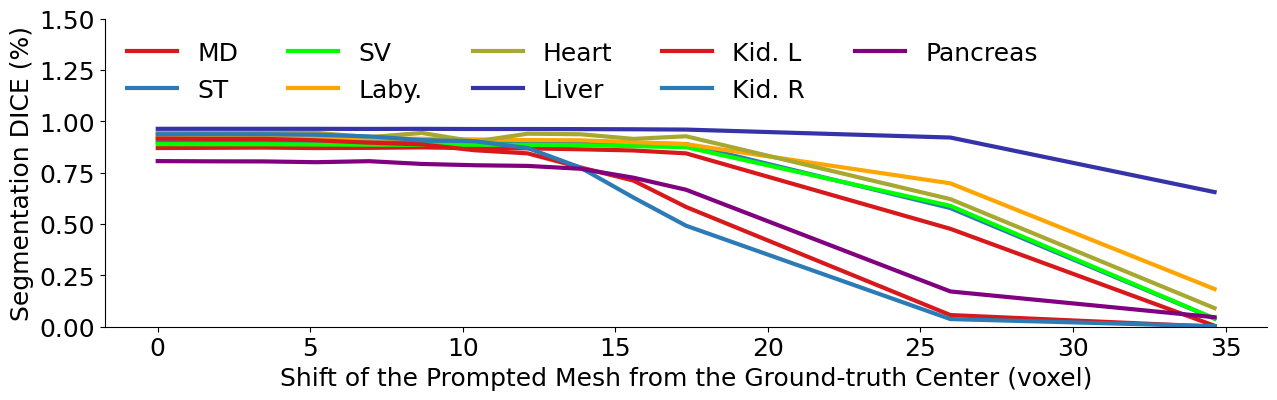

In [92]:
shifts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
cochlear_loc_res = [cochlear_l0, cochlear_l1, cochlear_l2, cochlear_l3, cochlear_l4, cochlear_l5, cochlear_l6,
                cochlear_l7, cochlear_l8, cochlear_l9, cochlear_l10, cochlear_l15, cochlear_l20]

body_loc_res = [body_l0, body_l1, body_l2, body_l3, body_l4, body_l5, body_l6,
                body_l7, body_l8, body_l9, body_l10, body_l15, body_l20]
errors = []

for s in cochlear_structures:
    cur = []
    for i, x in enumerate(shifts):
        cur.append(cochlear_loc_res[i][f'{s}_dice'].mean())
    errors.append(cur)

for s in body_structures:
    cur = []
    for i, x in enumerate(shifts):
        cur.append(body_loc_res[i][f'{s}_dice'].mean())
    errors.append(cur)

chart = Chart().set_figsize(15, 4)
chart.legend_fontsize = 18
chart.innertext_fontsize = 18
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)
chart.yticks(0, 1.5)

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

labels = ['MD', 'ST', 'SV', 'Laby.', 'Heart', 'Liver', 'Kid. L', 'Kid. R', 'Pancreas']
for i in range(len(labels)):
    label, error = labels[i], errors[i]
    chart.line(np.array(shifts) * np.sqrt(3), error, label=label, color=Chart.color_scheme2[i], linewidth=3)

chart.legend_loc = 'upper left'
chart.legend_ncol = 5
chart.xlabel('Shift of the Prompted Mesh from the Ground-truth Center (voxel)')
chart.ylabel('Segmentation DICE (%)')

chart.show_legend(frameon=False)


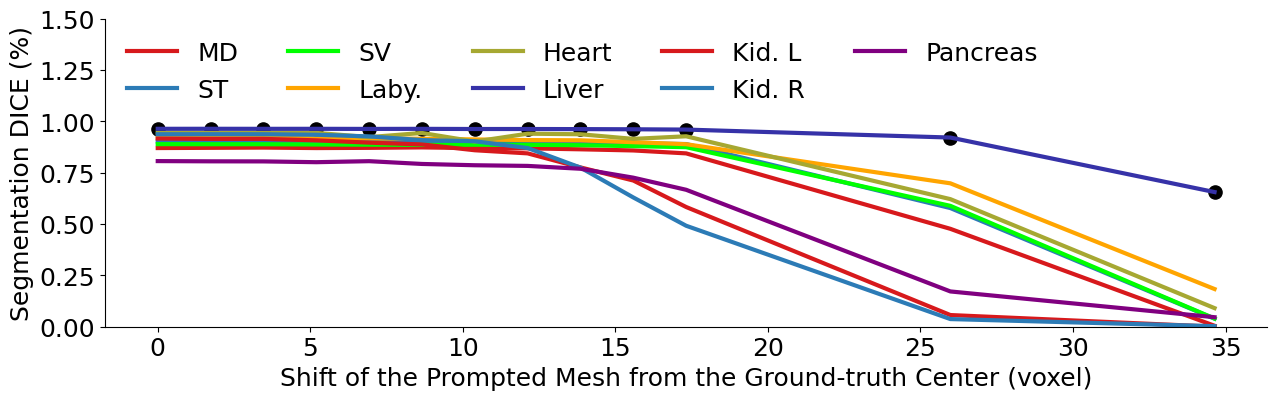

In [69]:
shifts = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
cochlear_loc_res = [cochlear_l0, cochlear_l1, cochlear_l2, cochlear_l3, cochlear_l4, cochlear_l5, cochlear_l6,
                cochlear_l7, cochlear_l8, cochlear_l9, cochlear_l10, cochlear_l15, cochlear_l20]

body_loc_res = [body_l0, body_l1, body_l2, body_l3, body_l4, body_l5, body_l6,
                body_l7, body_l8, body_l9, body_l10, body_l15, body_l20]
errors = []

for s in cochlear_structures:
    cur = []
    for i, x in enumerate(shifts):
        cur.append(cochlear_loc_res[i][f'{s}_dice'].mean())
    errors.append(cur)

for s in body_structures:
    cur = []
    for i, x in enumerate(shifts):
        cur.append(body_loc_res[i][f'{s}_dice'].mean())
    errors.append(cur)

chart = Chart().set_figsize(15, 4)
chart.legend_fontsize = 18
chart.innertext_fontsize = 18
chart.xlabel_fontsize = 18
chart.ylabel_fontsize = 18
chart.config(18, 18)
chart.yticks(0, 1.5)

chart.ax.spines.top.set_visible(False)
chart.ax.spines.right.set_visible(False)

labels = ['MD', 'ST', 'SV', 'Laby.', 'Heart', 'Liver', 'Kid. L', 'Kid. R', 'Pancreas']
for i in range(len(labels)):
    label, error = labels[i], errors[i]
    chart.line(np.array(shifts) * np.sqrt(3), error, label=label, color=Chart.color_scheme2[i], linewidth=3)
    if i == 5:
        chart.scatter(np.array(shifts) * np.sqrt(3), error, markersize=10, color='black')

chart.legend_loc = 'upper left'
chart.legend_ncol = 5
chart.xlabel('Shift of the Prompted Mesh from the Ground-truth Center (voxel)')
chart.ylabel('Segmentation DICE (%)')

chart.show_legend(frameon=False)


## Center Correspondence Error

In [26]:
body_center_error = pd.read_csv('../exp_same/Exp_body_128_1/evaluation/iter_20000_.csv')
cochlear_center_error = pd.read_csv('../exp_same/Exp_cochlear_128_1/evaluation/iter_20000_.csv')
body_center_original_same = pd.read_csv('G:/mipresearch/mps_data/body/strcture_center_original_same.csv')
body_center_original_same_256 = pd.read_csv('G:/mipresearch/mps_data/body/strcture_center_original_same_256.csv')
body_center_original_same_fpi = pd.read_csv('G:/mipresearch/mps_data/body/strcture_center_original_same_fpi.csv')
body_center_original_same_boundary_256 = pd.read_csv('G:/mipresearch/mps_data/body/strcture_center_original_same_boundary_256.csv')
body_center_original_same_boundary_fpi = pd.read_csv('G:/mipresearch/mps_data/body/strcture_center_original_same_boundary_fpi.csv')

In [32]:
body_center_original_same_boundary_fpi = body_center_original_same_boundary_fpi.dropna()

for i, row in body_center_original_same_boundary_fpi.iterrows():
    for k in body_structures:
        if k not in errors:
            errors[k] = []
        pred = np.array([float(x) for x in row[f'{k}_pred'][1: -1].split(' ') if x != ''])
        gt = np.array([float(x) for x in row[f'{k}_gt'][1: -1].split(' ') if x != ''])
        errors[k].append(np.sqrt(((pred - gt) ** 2).sum()))

for k, v in errors.items():
    print(k, np.mean(v) / 2, np.std(v) / 2)

heart 3.0207979648848897 1.4424695326644905
liver 6.377910034515159 3.00931554788238
kidney_left 5.718206764877087 4.820872194128524
kidney_right 3.603884085883428 1.8748048055023128
pancreas 4.587534065525273 2.812867488051556


In [55]:
center_errors_body = {}
for i, row in body_center_original_same_boundary_fpi.iterrows():
    for k in body_structures:
        if k not in center_errors_body:
            center_errors_body[k] = []
        pred = np.array([float(x) for x in row[f'{k}_pred'][1: -1].split(' ') if x != ''])
        gt = np.array([float(x) for x in row[f'{k}_gt'][1: -1].split(' ') if x != ''])
        center_errors_body[k].append(np.sqrt(((pred - gt) ** 2).sum()))

for k, v in center_errors_body.items():
    print(k, np.mean(v) / 2, np.std(v) / 2, np.max(v) / 2)

heart 3.82126108534343 0.889281091948487 6.324555320336759
liver 5.590429694558091 2.20091676483081 10.124228365658293
kidney_left 5.296223333961325 3.7006643127940246 24.50510150968569
kidney_right 3.8500772661777853 1.1532416351098256 9.069178573608527
pancreas 3.2688813433308415 1.625098574077415 7.582875444051551


In [56]:
center_errors_cochlear = {}
for i, row in cochlear_center_error.iterrows():
    for k in cochlear_structures:
        if k not in center_errors_cochlear:
            center_errors_cochlear[k] = []
        center_errors_cochlear[k].append(row[f'{k}_center_dist_center_avg'])

for k, v in center_errors_cochlear.items():
    print(k, np.mean(v), np.std(v), np.max(v))

md 1.4342522988505746 0.47526355869864373 2.7862
st 2.917587356321839 2.3914747012494195 11.919
sv 2.705224827586207 2.3163508086404656 11.25
cc 2.9905722988505743 2.7131208180493265 14.296


In [62]:
# divide by 2 for body is because they errors were calculated on 256 images instead of 128.
center_errors = [
    ['median'] + [np.percentile(center_errors_cochlear[k], 50) for k in cochlear_structures] + [np.percentile(center_errors_body[k], 50) / 2 for k in body_structures],
    ['75%'] + [np.percentile(center_errors_cochlear[k], 75) for k in cochlear_structures] + [np.percentile(center_errors_body[k], 75) / 2 for k in body_structures],
    ['max'] + [np.max(center_errors_cochlear[k]) for k in cochlear_structures] + [np.max(center_errors_body[k]) / 2 for k in body_structures],
]

for i in range(len(center_errors)):
    cochlear_avg = np.array(center_errors[i][1: 5]).mean()
    body_avg = np.array(center_errors[i][5: ]).mean()
    center_errors[i].insert(5, cochlear_avg)
    center_errors[i].append(body_avg)

pd.DataFrame(center_errors, columns=[''] + cochlear_structures + ['avg'] + body_structures + ['avg']).to_csv('center_error.csv', index=False)


In [46]:
cochlear_center_error[f'st_center_dist_center_avg'].mean()

2.917587356321839

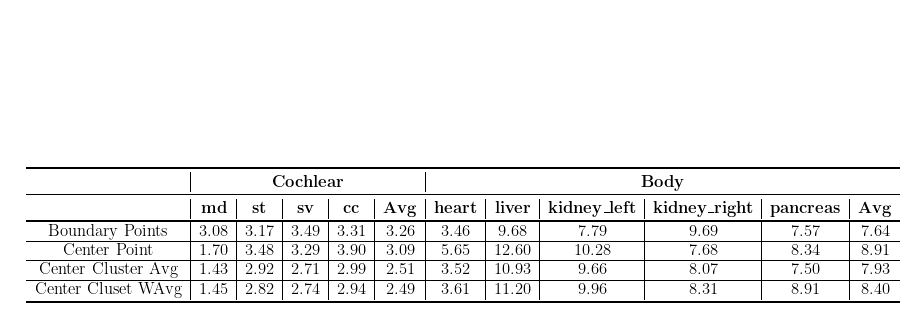

In [45]:
keys = ['center_dist_boundary', 'center_dist_center_avg', 'center_dist_center_wavg', 'center_dist_center']


header = [
    [''] + ['Cochlear'] * 5 + ['Body'] * 6,
    [''] + cochlear_structures + ['Avg'] + body_structures + ['Avg']
    ]

table_data = [
    ['Boundary Points'] + [cochlear_center_error[f'{k}_center_dist_boundary'].mean() for k in cochlear_structures] + [body_center_error[f'{k}_center_dist_boundary'].mean() for k in body_structures],
    ['Center Point'] + [cochlear_center_error[f'{k}_center_dist_center'].mean() for k in cochlear_structures] + [body_center_error[f'{k}_center_dist_center'].mean() for k in body_structures],
    ['Center Cluster Avg'] + [cochlear_center_error[f'{k}_center_dist_center_avg'].mean() for k in cochlear_structures] + [body_center_error[f'{k}_center_dist_center_avg'].mean() for k in body_structures],
    ['Center Cluset WAvg'] + [cochlear_center_error[f'{k}_center_dist_center_wavg'].mean() for k in cochlear_structures] + [body_center_error[f'{k}_center_dist_center_wavg'].mean() for k in body_structures],
]

for i in range(len(table_data)):
    cochlear_avg = np.array(table_data[i][1: 5]).mean()
    body_avg = np.array(table_data[i][5: ]).mean()
    table_data[i].insert(5, cochlear_avg)
    table_data[i].append(body_avg)

chart = Chart()
chart.table(data=table_data, headers=header, float_format='%.2f')

# pd.DataFrame(header + table_data).to_csv('chamfe_and_p2p_error.csv', index=False)


## Visual examples

In [5]:
def rescale_vol(vol, voxsz, std_voxsz, std_shape, fill=0):
    vol_rescaled = np.zeros(std_shape) + fill

    vol = rescale(vol, voxsz / std_voxsz, order = 0 if fill == 0 else None)
    center = np.array(vol.shape) // 2

    std_center = np.array(std_shape) // 2

    hsx = min(std_center[0], center[0])
    hsy = min(std_center[1], center[1])
    hsz = min(std_center[2], center[2])

    vol_rescaled[std_center[0]-hsx: std_center[0]+hsx, 
                std_center[1]-hsy: std_center[1]+hsy, 
                std_center[2]-hsz: std_center[2]+hsz] = vol[center[0]-hsx: center[0]+hsx,
                                            center[1]-hsy: center[1]+hsy, 
                                            center[2]-hsz: center[2]+hsz]
    return vol_rescaled

In [81]:
def plot_body(case, std_voxsz, std_shape, y_index, colors, cg):
    img = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/pat_img.nii.gz')
    affine, img_data = img.affine, img.get_fdata().astype(np.float32)
    voxsz = np.abs([affine[0, 0], affine[1, 1], affine[2, 2]])

    img_data = rescale_vol(img_data, voxsz, std_voxsz, std_shape, fill=img_data.min())

    sdf_preds = []
    image_preds = []
    nnunet_preds = []
    medsam2_preds = []  
    gts = []

    nnunet_pred_combined = nib.load(f'G:/mipresearch/mps_data/body/nnunet/predicted/{case}.nii.gz').get_fdata().astype(np.float32)
    medsam2_pred_combined = nib.load(f"E:/dingjie/mipresearch/Medical-SAM2/prediction_body/['{case}']_pred_mask.nii.gz").get_fdata().astype(np.float32)

    for i, s in enumerate(body_structures):
        gt = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/{s}_pat_mask.nii.gz').get_fdata().astype(np.float32)
        sdf_pred = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/{s}_a2p_mask.nii.gz').get_fdata().astype(np.float32)
        image_pred = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-image-mse-dice-downsample4_1/demo/{case}/{s}_a2p_mask.nii.gz').get_fdata().astype(np.float32)
        nnunet_pred = (nnunet_pred_combined == (i + 1)).astype(np.float32)
        medsam2_pred = np.transpose(medsam2_pred_combined[i], [1, 0, 2])
        sdf_preds.append(rescale_vol(sdf_pred, voxsz, std_voxsz, std_shape, fill=0))
        image_preds.append(rescale_vol(image_pred, voxsz, std_voxsz, std_shape, fill=0))
        nnunet_preds.append(rescale_vol(nnunet_pred, voxsz, std_voxsz, std_shape, fill=0))

        medsam2_pred_temp = rescale_vol(medsam2_pred, voxsz, std_voxsz, std_shape, fill=0)
        labels = label(medsam2_pred_temp)
        medsam2_pred_temp = (labels == np.argmax(np.bincount(labels.flat)[1:])+1)
        medsam2_pred = binary_fill_holes(medsam2_pred_temp, structure=np.ones((2, 2, 2))).astype(np.float32)

        medsam2_preds.append(medsam2_pred)
        gts.append(rescale_vol(gt, voxsz, std_voxsz, std_shape, fill=0))

    for i, item in enumerate([sdf_preds, image_preds, nnunet_preds, medsam2_preds, gts]):
        chart = cg.get_chart(1, i + 1)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
        chart.axis_off()
        chart.slice(img_data, orientation='y', slice_index=y_index, voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
    
    chart6 = cg.get_chart(1, 6)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
    chart6.axis_off()
    chart6.slice(img_data, orientation='y', slice_index=y_index, voxsz=[1, 1, 1])

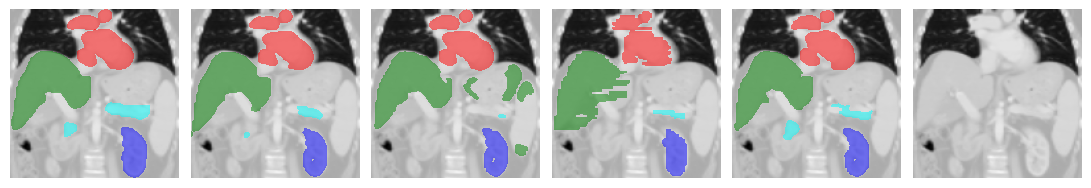

In [82]:
# body_cases = ['s0754', 's0086', 's0447', 's0550']

cg = ChartGroup(1, 6, each_width=2, each_height=2)

std_voxsz = np.array([2.5, 2.5, 2.5])
std_shape = np.array([128, 128, 128])

colors = ['red', 'green', 'blue', 'yellow', 'cyan']

case = 's0754'
plot_body(case, std_voxsz, std_shape, y_index='mid', colors=colors, cg=cg)

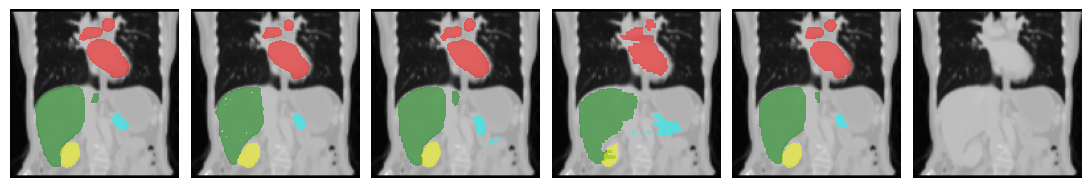

In [83]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

std_voxsz = np.array([2.5, 2.5, 2.5])
std_shape = np.array([128, 128, 128])

colors = ['red', 'green', 'blue', 'yellow', 'cyan']

case = 's0447'
plot_body(case, std_voxsz, std_shape, y_index=50, colors=colors, cg=cg)

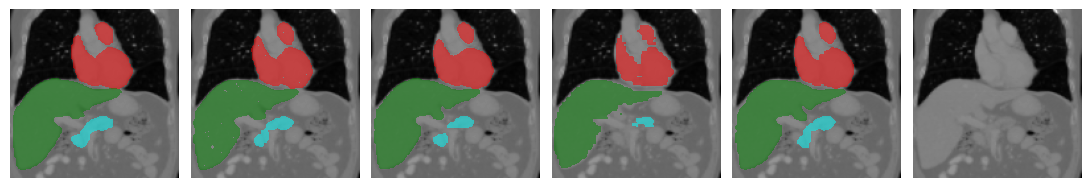

In [84]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

std_voxsz = np.array([2.5, 2.5, 2.5])
std_shape = np.array([128, 128, 128])

colors = ['red', 'green', 'blue', 'yellow', 'cyan']

case = 's0550'
plot_body(case, std_voxsz, std_shape, y_index=40, colors=colors, cg=cg)

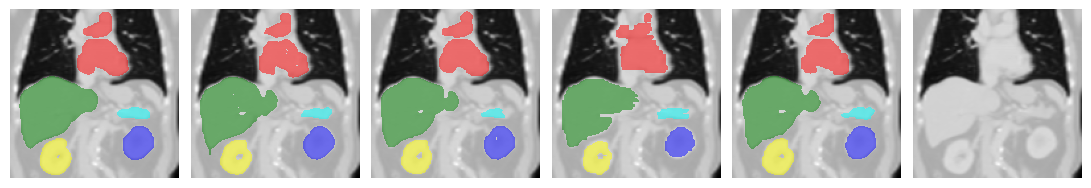

In [71]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

std_voxsz = np.array([2.5, 2.5, 2.5])
std_shape = np.array([128, 128, 128])

colors = ['red', 'green', 'blue', 'yellow', 'cyan']

case = 's0086'
plot_body(case, std_voxsz, std_shape, y_index=50, colors=colors, cg=cg)

In [74]:
def plot_cochlear(case, z_index, colors, cg, structure_order):
    img = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/pat_img.nii.gz')
    affine, img_data = img.affine, img.get_fdata().astype(np.float32)
    voxsz = np.abs([affine[0, 0], affine[1, 1], affine[2, 2]])

    sdf_preds = []
    image_preds = []
    nnunet_preds = []
    medsam2_preds = []
    gts = []

    
    medsam2_pred_combined = nib.load(f"E:/dingjie/mipresearch/Medical-SAM2/prediction_cochlear/['{case}']_pred_mask.nii.gz").get_fdata().astype(np.float32)

    nnunet_pred_cc = nib.load(f'G:/mipresearch/mps_data/cochlear/result/nnunet_cc_prediction/{case}.nii.gz').get_fdata().astype(np.float32)
    nnunet_pred_stsv = nib.load(f'G:/mipresearch/mps_data/cochlear/result/nnunet_stsv_prediction/{case}.nii.gz').get_fdata().astype(np.float32)
    nnunet_pred_md = nib.load(f'G:/mipresearch/mps_data/cochlear/result/nnunet_md_prediction/{case}.nii.gz').get_fdata().astype(np.float32)

    nnunet_pred_st = (nnunet_pred_stsv == 1).astype(np.float32)
    nnunet_pred_sv = (nnunet_pred_stsv == 2).astype(np.float32)
    nnunet_res = {'md': nnunet_pred_md, 'st': nnunet_pred_st, 'sv': nnunet_pred_sv, 'cc': nnunet_pred_cc}

    for i, s in enumerate(structure_order):
        gt = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/{s}_pat_mask.nii.gz').get_fdata().astype(np.float32)
        sdf_pred = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_cochlear-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/{s}_a2p_mask.nii.gz').get_fdata().astype(np.float32)
        image_pred = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_cochlear-vfa-image-mse-dice-downsample4_1/demo/{case}/{s}_a2p_mask.nii.gz').get_fdata().astype(np.float32)
        if s == 'md':
            medsam2_pred = np.transpose(medsam2_pred_combined[0], [1, 0, 2])
        if s == 'st':
            medsam2_pred = np.transpose(medsam2_pred_combined[1], [1, 0, 2])
        if s == 'sv':
            medsam2_pred = np.transpose(medsam2_pred_combined[2], [1, 0, 2])
        if s == 'cc':
            medsam2_pred = np.transpose(medsam2_pred_combined[3], [1, 0, 2])
        sdf_preds.append(sdf_pred)
        image_preds.append(image_pred)
        nnunet_preds.append(nnunet_res[s])

        # medsam2_pred_temp = medsam2_pred
        # labels = label(medsam2_pred_temp)
        # medsam2_pred_temp = (labels == np.argmax(np.bincount(labels.flat)[1:])+1)
        # medsam2_pred = binary_fill_holes(medsam2_pred_temp, structure=np.ones((2, 2, 2))).astype(np.float32)

        medsam2_preds.append(medsam2_pred)
        gts.append(gt)

    for i, item in enumerate([sdf_preds, image_preds, nnunet_preds, medsam2_preds, gts]):
        chart = cg.get_chart(1, i + 1)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
        chart.axis_off()
        chart.slice(np.flip(img_data, 1)[20: 108, 20: 108, 20: 108], orientation='z', slice_index=z_index, voxsz=[1, 1, 1], mask_overlays=[[np.flip(mask, 1)[20: 108, 20: 108, 20: 108], color] for mask, color in zip(item, colors)])

    chart6 = cg.get_chart(1, 6)
        # chart.slice(img_data, orientation='y', voxsz=[1, 1, 1], mask_overlays=[[mask, color] for mask, color in zip(item, colors)])
    chart6.axis_off()
    chart6.slice(np.flip(img_data, 1)[20: 108, 20: 108, 20: 108], orientation='z', slice_index=z_index, voxsz=[1, 1, 1])

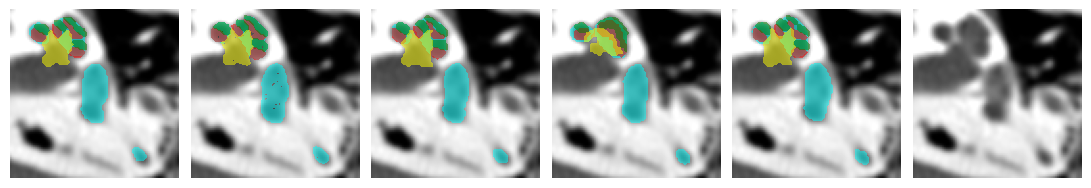

In [88]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['cc', 'st', 'sv', 'md']

plot_cochlear('PID_1689_PLANID_1096_LEFT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

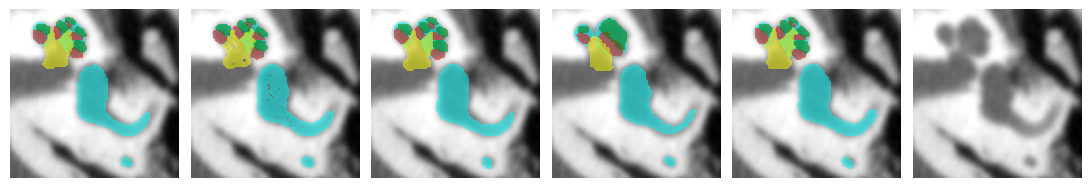

In [76]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['cc', 'st', 'sv', 'md']

plot_cochlear('PID_1724_PLANID_1372_LEFT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

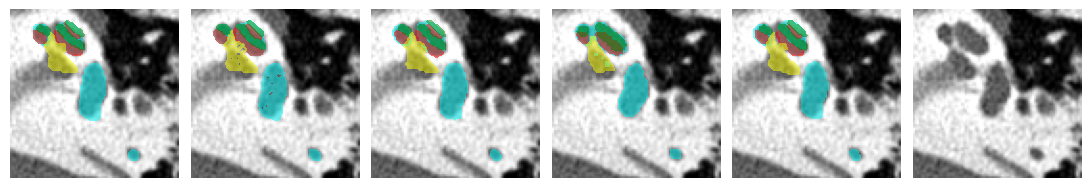

In [77]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['cc', 'st', 'sv', 'md']

plot_cochlear('PID_1941_PLANID_523_RIGHT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

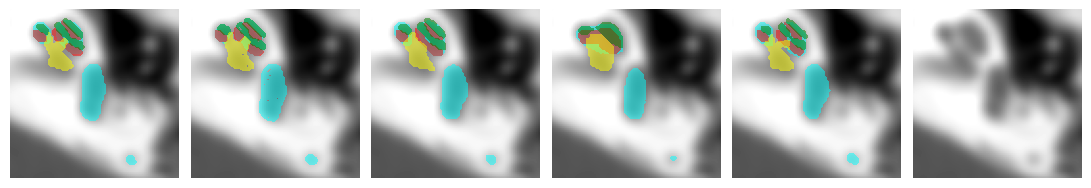

In [78]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['cc', 'st', 'sv', 'md']

plot_cochlear('PID_2182_PLANID_878_RIGHT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

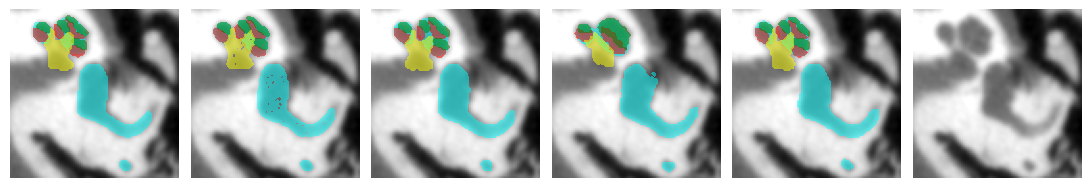

In [79]:
cg = ChartGroup(1, 6, each_width=2, each_height=2)

colors = ['cyan', 'red', 'green', 'yellow']
structure_order = ['cc', 'st', 'sv', 'md']

plot_cochlear('PID_1724_PLANID_1373_RIGHT', z_index=30, colors=colors, structure_order=structure_order, cg=cg)

In [57]:
def plot_body_move(case, std_voxsz, std_shape, y_index, colors, cg):
    img = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/pat_img.nii.gz')
    affine, img_data = img.affine, img.get_fdata().astype(np.float32)
    voxsz = np.abs([affine[0, 0], affine[1, 1], affine[2, 2]])
    affine_atlas = nib.load(f'G:/mipresearch/mps_data/body/processed/s0686/img.nii.gz').affine
    voxsz_atlas = np.abs([affine_atlas[0, 0], affine_atlas[1, 1], affine_atlas[2, 2]])

    pat_kid_mesh = pv.read(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/kidney_right_pat_mesh.ply')
    pat_kid_center = np.array(pat_kid_mesh.points).mean(axis=0).round().astype(int)
    pat_kid_mask = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/kidney_right_pat_mask.nii.gz').get_fdata().astype(np.float32)

    atlas_kid_mesh = pv.read('G:/mipresearch/mps_data/body/processed/s0686/kidney_right_mesh.ply')
    atlas_kid_center = np.array(atlas_kid_mesh.points).mean(axis=0).round().astype(int)
    atlas_kid_mask = nib.load(f'G:/mipresearch/mps_data/body/processed/s0686/kidney_right.nii.gz').get_fdata().astype(np.float32)

    atlas_in_pat_kid_mask = np.zeros_like(atlas_kid_mask)
    m = 20
    x1, y1, z1 = pat_kid_center
    x2, y2, z2 = atlas_kid_center
    atlas_in_pat_kid_mask[x1 - m: x1 + m, y1 - m: y1 + m, z1 - m: z1 + m] = atlas_kid_mask[x2 - m: x2 + m, y2 - m: y2 + m, z2 - m: z2 + m]


    img_data = rescale_vol(img_data, voxsz, std_voxsz, std_shape, fill=img_data.min())
    mask_pat = rescale_vol(pat_kid_mask, voxsz, std_voxsz, std_shape, fill=0)
    mask_a0 = rescale_vol(atlas_in_pat_kid_mask, voxsz_atlas, std_voxsz, std_shape, fill=0)

    atlas_masks = [mask_a0]

    for s in [5, 10, 20]:
        mask_ax = np.zeros_like(mask_a0)
        mask_ax[s:, :, :] = mask_a0[:-s, :, :]
        atlas_masks.append(mask_ax)
    
    x_max, z_max = 80, 80
    img_data = img_data[: x_max, :, : z_max]
    mask_pat = mask_pat[: x_max, :, : z_max]

    for i in range(len(atlas_masks)):
        atlas_masks[i] = atlas_masks[i][: x_max, :, : z_max]


    # # gt = nib.load(f'E:/dingjie/mipresearch/SMP/exp_midl/Exp_body-vfa-sdf-chamfer-loc_r5_downsample4_1/demo/{case}/kidney_right_pat_mask.nii.gz').get_fdata().astype(np.float32)
    # gt = nib.load(f'G:/mipresearch/mps_data/body/processed/s0686/kidney_right.nii.gz').get_fdata().astype(np.float32)

    # gt = rescale_vol(gt, voxsz, std_voxsz, std_shape, fill=0)

    # img_data = img_data[: 64, :, : 64]
    # gt = gt[: 64, :, : 64]

    # gt1 = np.zeros_like(gt)
    # gt1[5:, :, :] = gt[:-5, :, :]

    for i in range(len(atlas_masks)):
        chart = cg.get_chart(1, i + 1)
        chart.axis_off()
        chart.slice(img_data, orientation='y', slice_index=y_index, voxsz=[1, 1, 1], contour_overlays=[[mask_pat, 'red'], [atlas_masks[i], 'blue']], contour_overlay_linewidth=3)

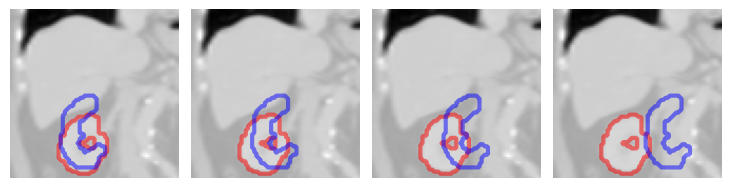

In [58]:
cg = ChartGroup(1, 4, each_width=2, each_height=2)

std_voxsz = np.array([2.5, 2.5, 2.5])
std_shape = np.array([128, 128, 128])

colors = ['red', 'green', 'blue', 'yellow', 'cyan']

case = 's0086'
plot_body_move(case, std_voxsz, std_shape, y_index=50, colors=colors, cg=cg)